In [3]:
import os 
import pandas as pd
import glob
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import cv2
from sklearn.metrics import multilabel_confusion_matrix
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from PIL import Image
import random
import albumentations as A
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [4]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "/media/aaron/Local Disk/ANN/COVID-19 Radiography Database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-1.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
1,Normal/images/Normal-10.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
2,Normal/images/Normal-100.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
3,Normal/images/Normal-1000.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...
4,Normal/images/Normal-10000.png,Normal,/media/aaron/Local Disk/ANN/COVID-19 Radiograp...


In [5]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 21165


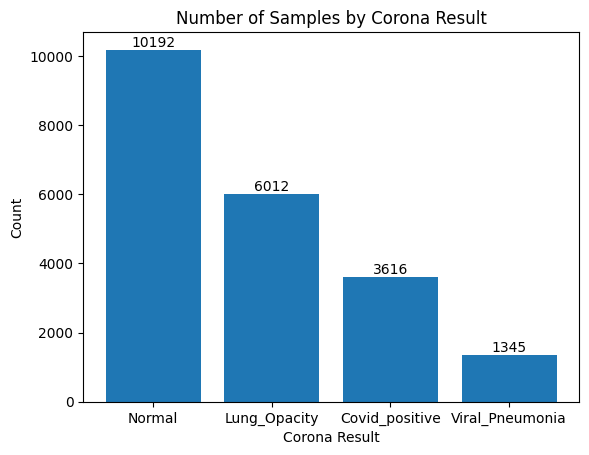

In [6]:
no_of_samples = 21165
df = pd.DataFrame()
df['corona_result'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [len(data[data['corona_result'] == 'Normal']), len(data[data['corona_result'] == 'Covid_positive']), len(data[data['corona_result'] == 'Lung_Opacity']), len(data[data['corona_result'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

plt.bar(df['corona_result'], df['Count'])
plt.xlabel('Corona Result')
plt.ylabel('Count')
plt.title('Number of Samples by Corona Result')

# Add labels outside the bars
for i, count in enumerate(df['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [8]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [9]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, no_of_samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

In [10]:
mean_normal = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
mean_covid = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
mean_opacity = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
mean_pneumonia = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
mean_list = [mean_normal,mean_covid,mean_opacity,mean_pneumonia]

max_normal = imageEDA["max"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
max_covid = imageEDA["max"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
max_opacity = imageEDA["max"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
max_pneumonia = imageEDA["max"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
max_list = [max_normal,max_covid,max_opacity,max_pneumonia]

min_normal = imageEDA["min"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
min_covid = imageEDA["min"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
min_opacity = imageEDA["min"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
min_pneumonia = imageEDA["min"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
min_list = [min_normal,min_covid,min_opacity,min_pneumonia]

std_normal = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
std_covid = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
std_opacity = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
std_pneumonia = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
std_list = [std_normal,std_covid,std_opacity,std_pneumonia]

Names = ['Normal','Covid','Lung opacity','Pneumonia']

In [11]:
def min_max_plot(data, names, title):
    colors = ['#04EEFF', '#4BBBFF', '#F5F232', '#7FFF00']
    
    # Create subplots with a shared y-axis
    fig, ax = plt.subplots()
    
    # Iterate over the data and names
    for i in range(len(data)):
        bins = np.linspace(min(data[i]), max(data[i]), 50)  # Define the bin edges for the histogram
        
        # Create the histogram for each set of data
        ax.hist(data[i], bins=bins, density=True, alpha=0.5, color=colors[i % len(colors)], label=names[i])
    
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.legend()
    
    plt.show()


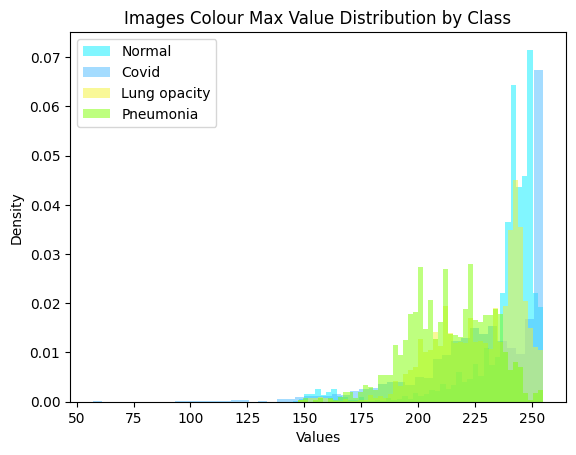

In [12]:
min_max_plot(max_list,Names,"Images Colour Max Value Distribution by Class")

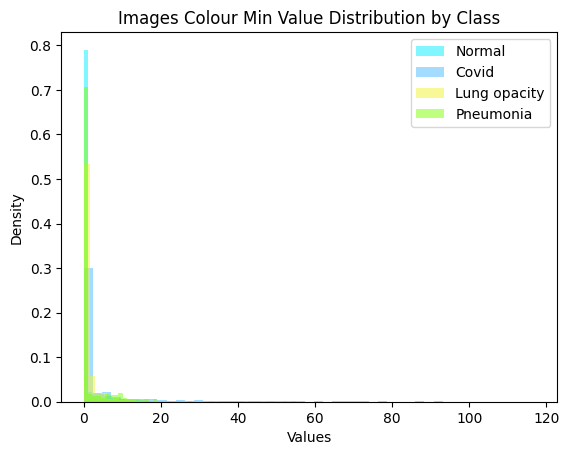

In [13]:
min_max_plot(min_list,Names,"Images Colour Min Value Distribution by Class")

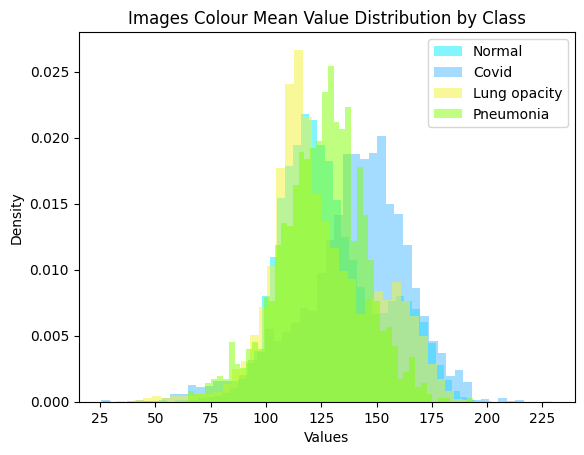

In [14]:
min_max_plot(mean_list,Names,"Images Colour Mean Value Distribution by Class")

In [2]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    image_generator = ImageDataGenerator(
        samplewise_center=True, 
        samplewise_std_normalization= True, 
        rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
                                                     
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="grayscale",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

def get_filepath_from_generator(gen):
    if gen.batch_index <=0:
        raise ValueError('Use iterator to move to batch_index > 0')
    idx_l = (gen.batch_index - 1) * gen.batch_size
    idx_r = idx_l + gen.batch_size if idx_l >= 0 else None
    indices = gen.index_array[idx_l:idx_r]
    filenames = [gen.filenames[i] for i in indices]
    return indices, filenames
    



In [3]:
folder_path = '//media//aaron//Local Disk//ANN//COVID-19 Radiography Database//COVID-19_Radiography_Dataset//'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


In [4]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [5]:
def cnn_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    i = Input(shape=(size, size, 1))  
    x = BatchNormalization()(i)
    x = Conv2D(64, 3, activation='relu')(x)  
    x = MaxPooling2D()(x)
    x = Dropout(0.5)(x)  

    x = Conv2D(128, 3, activation='relu')(x)  
    x = Conv2D(128, 3, activation='relu')(x)  
    x = MaxPooling2D()(x)
    x = Dropout(0.5)(x)

 

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)  
    x = Dropout(0.5)(x)  


    x = Dense(4, activation='softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 1,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 
    

In [6]:
epochs = 20
r,model,n_epochs = cnn_model(train_data, val_data,epochs,128)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None

2023-07-09 19:16:02.789505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 19:16:02.808317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 19:16:02.808530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 19:16:02.809340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

----Training the network----
Epoch 1/20


2023-07-09 19:16:05.162222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-07-09 19:16:06.529134: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Not a directory
2023-07-09 19:16:06.529918: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Not a directory
2023-07-09 19:16:06.529934: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-09 19:16:06.530564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: Not a directory
2023-07-09 19:16:06.530612: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-07-09 19:16:08.133422: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-

926/926 [==============================] - ETA: 0s - loss: 0.9393 - accuracy: 0.6012

2023-07-09 19:17:56.002716: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-09 19:17:56.323344: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.67812, saving model to cnn_model.h5


2023-07-09 19:17:56.693834: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-09 19:17:57.118588: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.
2023-07-09 19:17:57.406396: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 220463104 exceeds 10% of free system memory.


926/926 [==============================] - 115s 116ms/step - loss: 0.9393 - accuracy: 0.6012 - val_loss: 0.6781 - val_accuracy: 0.7239
Epoch 2/20
926/926 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.6774
Epoch 2: val_loss improved from 0.67812 to 0.57999, saving model to cnn_model.h5
926/926 [==============================] - 103s 112ms/step - loss: 0.7682 - accuracy: 0.6774 - val_loss: 0.5800 - val_accuracy: 0.7683
Epoch 3/20
926/926 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.7121
Epoch 3: val_loss improved from 0.57999 to 0.50825, saving model to cnn_model.h5
926/926 [==============================] - 100s 108ms/step - loss: 0.7019 - accuracy: 0.7121 - val_loss: 0.5083 - val_accuracy: 0.8086
Epoch 4/20
926/926 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7371
Epoch 4: val_loss improved from 0.50825 to 0.47998, saving model to cnn_model.h5
926/926 [==============================] - 98s 106ms/step - loss

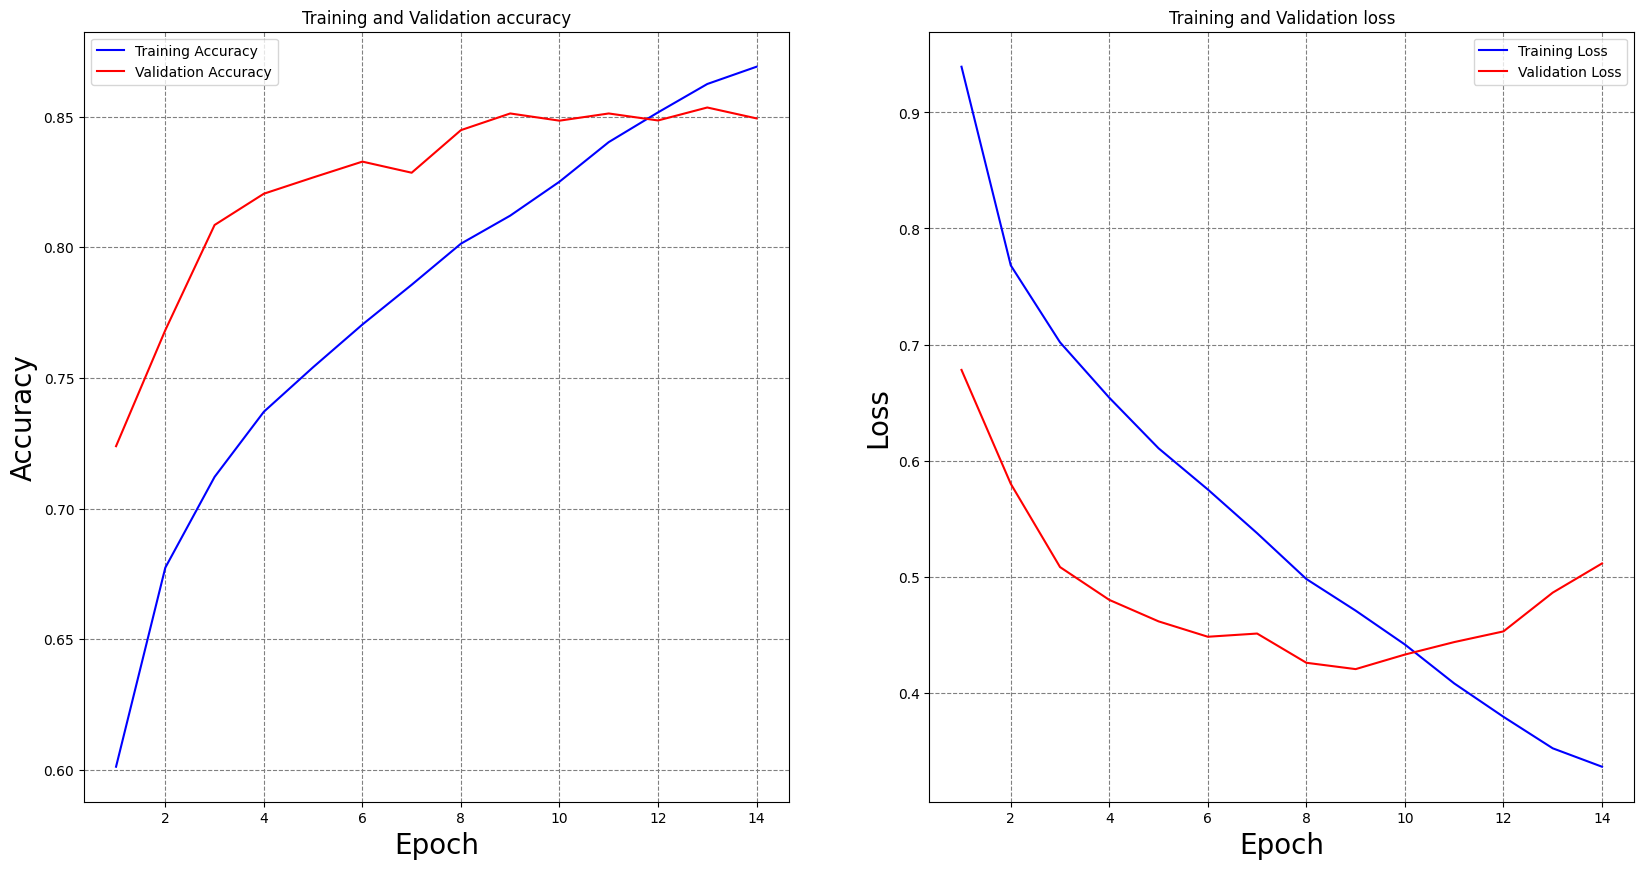

In [7]:
plotLearningCurve(r,n_epochs)

In [8]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

397/397 [==============================] - 19s 47ms/step - loss: 0.4203 - accuracy: 0.8512
Test Accuracy using CNN: 85.12%
926/926 [==============================] - 37s 40ms/step - loss: 0.3379 - accuracy: 0.8769
Train Accuracy using CNN: 87.69%


In [9]:
def extract_from_generator(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y


In [10]:
X_train,y_train = extract_from_generator(train_data)
print('X_train:',X_train.shape,'y_train:',y_train.shape)

100%|█████████████████████████████████████████| 925/925 [06:13<00:00,  2.47it/s]

X_train: (29632, 128, 128, 1) y_train: (29632, 4)


In [11]:
X_test,y_test = extract_from_generator(val_data)
print('X_test:',X_test.shape,'y_test:',y_test.shape)

100%|█████████████████████████████████████████| 395/395 [01:16<00:00,  5.19it/s]

X_test: (12672, 128, 128, 1) y_test: (12672, 4)


In [12]:
y_pred  = np.round(model.predict(X_test))

396/396 [==============================] - 8s 19ms/step


In [13]:
y_test_c = np.argmax(y_test,axis = 1) 
y_pred_c = np.argmax(y_pred,axis = 1)

In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2163
           1       0.87      0.73      0.80      3603
           2       0.86      0.90      0.88      6101
           3       0.91      0.86      0.89       805

   micro avg       0.86      0.84      0.85     12672
   macro avg       0.87      0.83      0.85     12672
weighted avg       0.86      0.84      0.85     12672
 samples avg       0.84      0.84      0.84     12672



/home/aaron/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
